1.Configuración del ambiente

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import yfinance as yf
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import datetime 
import pytz
from pandas.plotting import autocorrelation_plot

2.Obtención de Datos

Precios históricos del bitcoin

In [39]:
# La biblioteca yfinance de Python permite extraer datos financieros de Yahoo Finance.

def importar_base_bitcoin():
  global df_bitcoin
  data = yf.Ticker("BTC-USD").history(period='7d', interval='5m')
  df_bitcoin = pd.DataFrame(data)
  return df_bitcoin

importar_base_bitcoin()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-22 00:00:00+00:00,29918.654297,29921.863281,29904.357422,29904.357422,0,0.0,0.0
2023-10-22 00:05:00+00:00,29901.482422,29904.847656,29900.773438,29904.833984,0,0.0,0.0
2023-10-22 00:10:00+00:00,29915.406250,29939.906250,29915.406250,29939.472656,8702976,0.0,0.0
2023-10-22 00:15:00+00:00,29948.679688,29960.902344,29948.679688,29960.210938,31777792,0.0,0.0
2023-10-22 00:20:00+00:00,29963.044922,29963.503906,29961.232422,29961.232422,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-28 02:30:00+00:00,33931.121094,33931.121094,33920.160156,33920.281250,222208,0.0,0.0
2023-10-28 02:35:00+00:00,33921.476562,33923.492188,33921.023438,33921.980469,0,0.0,0.0
2023-10-28 02:40:00+00:00,33919.890625,33919.890625,33917.843750,33918.375000,27897856,0.0,0.0


Indicadores de tendencias

In [40]:
def extraer_tendencias():
    global precio_actual,tendencia
    url = 'https://coinmarketcap.com/'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    precio_btc = soup.find('div', class_='sc-a0353bbc-0 gDrtaY').get_text()
    precio_btc = precio_btc.replace(',', '')
    precio_btc = precio_btc.replace('$', '')
    precio_actual = float(precio_btc)
    icon = soup.findAll('span', {'class':['sc-d55c02b-0 iwhBxy']})[0]
    if 'sc-d55c02b-0 iwhBxy' in ' '.join(icon['class']):
        tendencia = 'alta'
    else:
        tendencia = 'baja'
    variacion = soup.find('span', class_='sc-d55c02b-0 iwhBxy').get_text()
    print(f'Precio actual de Bitcoin: {precio_actual}\nTendencia: {tendencia}\nVariación: {variacion}')
    # return  [precio_actual, tendencia, variacion]
    

extraer_tendencias()

Precio actual de Bitcoin: 33988.47
Tendencia: alta
Variación: 0.24%


3.Limpieza de datos

In [41]:
def limpieza_datos():
  global media_bitcoin,df_bitcoin_limpio
  df = importar_base_bitcoin()
  df_bitcoin_limpio = df.copy()
  indices_unicos = df_bitcoin_limpio.index.drop_duplicates()
  df_bitcoin_limpio = df_bitcoin_limpio.reindex(indices_unicos)
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
  close = df_bitcoin_limpio['Close']
  Q1 = close.quantile(.25)
  Q3 = close.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  seleccion = ((close >= Q1) & (close < Q3))
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  return [df_bitcoin_limpio, Q1, Q3]

limpieza_datos()

[                                   Open          High           Low  \
 Datetime                                                              
 2023-10-23 03:50:00+00:00  30650.539062  30683.857422  30602.603516   
 2023-10-23 03:55:00+00:00  30665.847656  30747.738281  30665.847656   
 2023-10-23 04:00:00+00:00  30728.923828  30791.951172  30714.619141   
 2023-10-23 04:05:00+00:00  30785.207031  30792.054688  30652.412109   
 2023-10-23 04:10:00+00:00  30655.880859  30661.757812  30642.345703   
 ...                                 ...           ...           ...   
 2023-10-28 02:20:00+00:00  33919.707031  33920.289062  33915.589844   
 2023-10-28 02:30:00+00:00  33931.121094  33931.121094  33920.160156   
 2023-10-28 02:40:00+00:00  33919.890625  33919.890625  33917.843750   
 2023-10-28 02:45:00+00:00  33924.804688  33971.980469  33920.437500   
 2023-10-28 02:50:00+00:00  33967.273438  34101.472656  33967.273438   
 
                                   Close     Volume  Dividends

In [42]:
sns.set(style="darkgrid")
datos_limpios = limpieza_datos()[0]

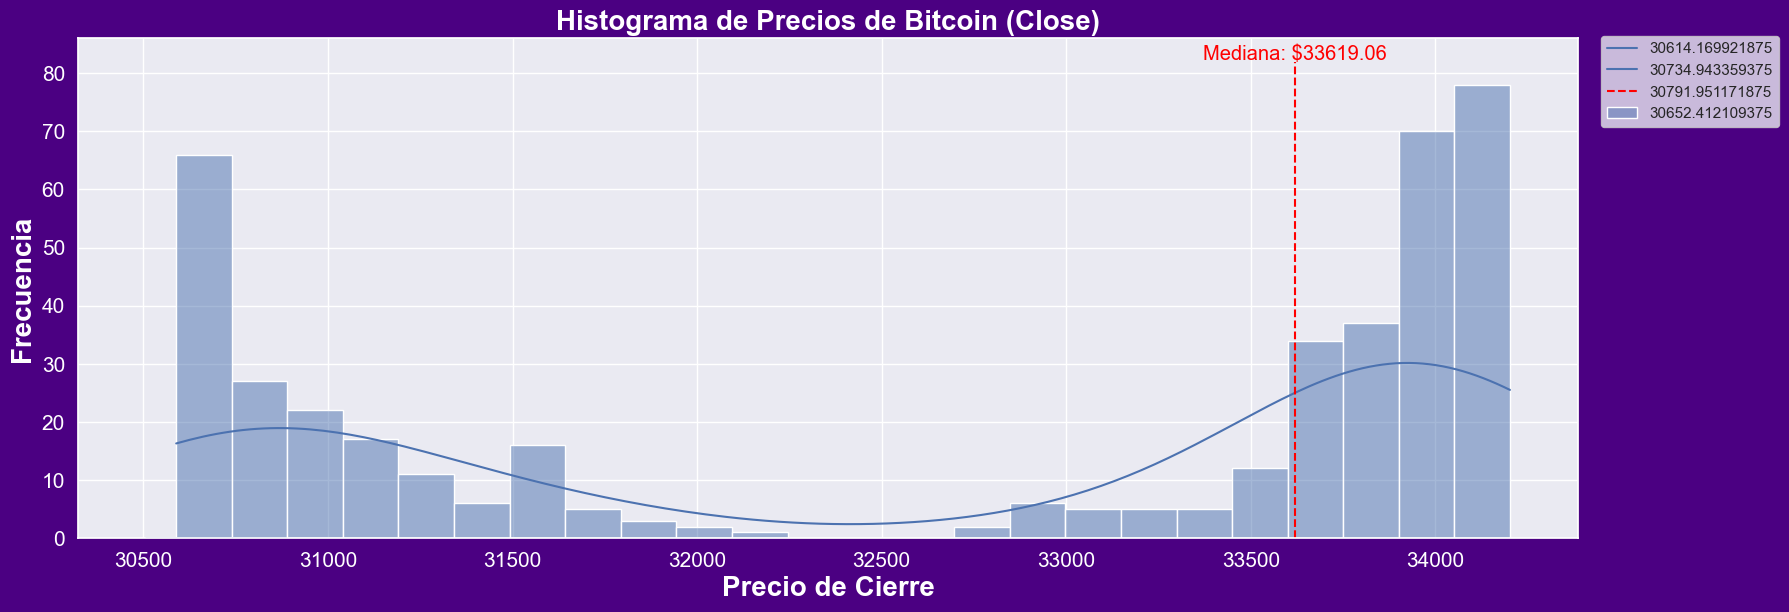

In [43]:
def hist():
    fig = plt.figure(figsize=(15, 5), facecolor='indigo')
    eje = fig.add_axes([0, 0, 1, 1])
    datos_limpios = limpieza_datos()[0]
    close = datos_limpios['Close']
    datos_limpios['Close'].head(10).plot.density()
    # eje.hist(close, bins=30, color='skyblue', edgecolor='black')
    sns.histplot(data=datos_limpios, x=close,bins=24, kde=True );
    mediana = close.median()
    eje.vlines(x=mediana, ymin=0, ymax=eje.get_ylim()[1], color='red', linestyle='dashed', label='Mediana')
    eje.set_title('Histograma de Precios de Bitcoin (Close)', fontsize=20, fontweight='bold', color='w')
    eje.set_xlabel('Precio de Cierre', fontsize=20, fontweight='bold', color='w')
    eje.set_ylabel('Frecuencia', fontsize=20, fontweight='bold', color='w')
    eje.tick_params(axis='x', colors='w', labelsize=15)
    eje.tick_params(axis='y', colors='w', labelsize=15)
    eje.annotate(f'Mediana: ${round(mediana, 2)}', xy=(mediana, eje.get_ylim()[1]-1.05), ha='center', va='top', color='red', fontsize=14.5)
    plt.legend(close,bbox_to_anchor=(1.01, 1.02), loc='upper left')
    plt.gray()
    plt.show()
hist()

In [44]:
datos_limpios.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-23 03:50:00+00:00,30650.539062,30683.857422,30602.603516,30614.169922,348778496,0.0,0.0
2023-10-23 03:55:00+00:00,30665.847656,30747.738281,30665.847656,30734.943359,188186624,0.0,0.0
2023-10-23 04:00:00+00:00,30728.923828,30791.951172,30714.619141,30791.951172,263048192,0.0,0.0
2023-10-23 04:05:00+00:00,30785.207031,30792.054688,30652.412109,30652.412109,82834432,0.0,0.0
2023-10-23 04:10:00+00:00,30655.880859,30661.757812,30642.345703,30642.345703,125168640,0.0,0.0


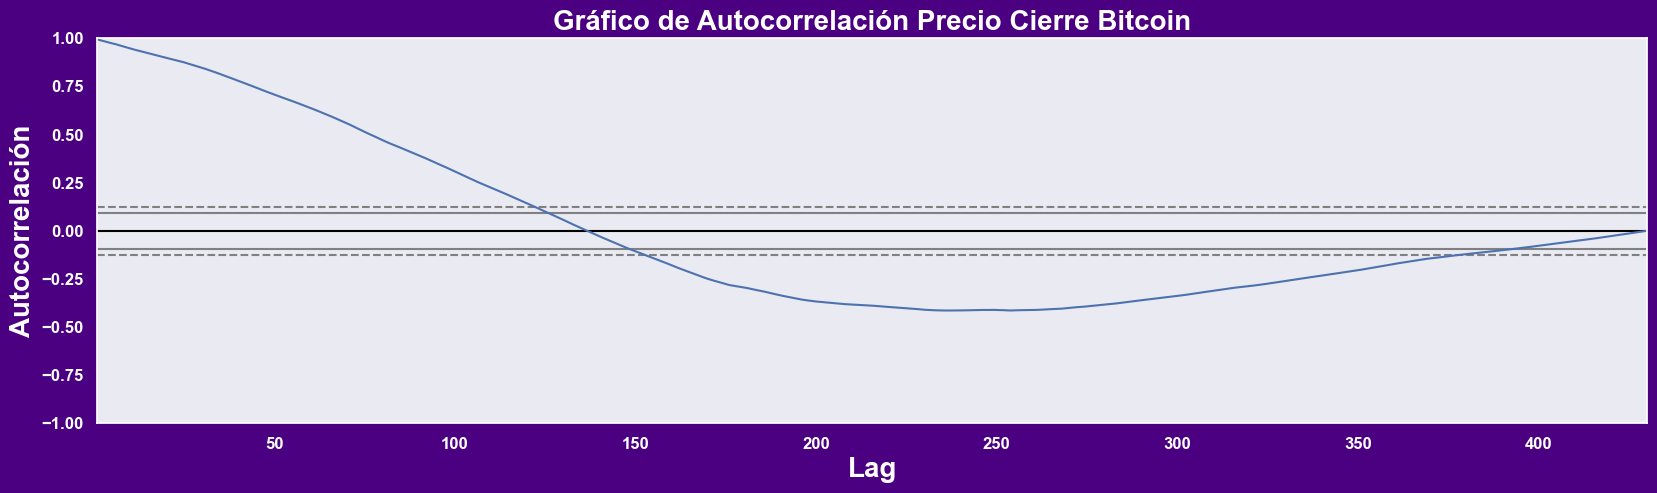

In [45]:
def autocorrelacion():
    plt.figure(figsize=(20, 5), facecolor='indigo')
    autocorrelation_plot(datos_limpios['Close'])
    plt.title('Gráfico de Autocorrelación Precio Cierre Bitcoin',color='w', size=20, fontweight='bold', loc='center')
    plt.xlabel('Lag',color='w', fontweight='bold', size=20)
    plt.ylabel('Autocorrelación',color='w',fontweight='bold', size=20)
    plt.xticks(fontweight='bold', fontsize=12, color='white')  # Haz que los números del eje x sean más gruesos
    plt.yticks(fontweight='bold', fontsize=12, color='white')  # Haz que los números del eje y sean más gruesos
    plt.show()
autocorrelacion()

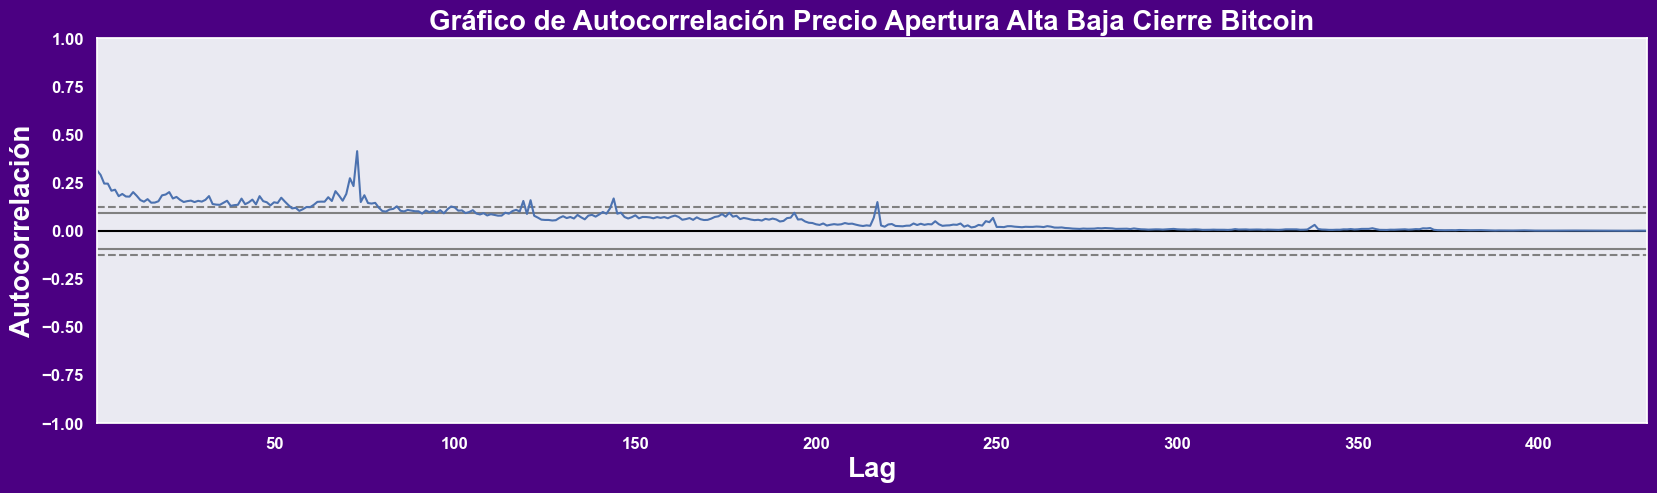

In [46]:
def autocorrelacion():
    plt.figure(figsize=(20, 5), facecolor='indigo')
    autocorrelation_plot(datos_limpios)
    plt.title('Gráfico de Autocorrelación Precio Apertura Alta Baja Cierre Bitcoin',color='w', size=20, fontweight='bold', loc='center')
    plt.xlabel('Lag',color='w', fontweight='bold', size=20)
    plt.ylabel('Autocorrelación',color='w',fontweight='bold', size=20)
    plt.xticks(fontweight='bold', fontsize=12, color='white')  # Haz que los números del eje x sean más gruesos
    plt.yticks(fontweight='bold', fontsize=12, color='white')  # Haz que los números del eje y sean más gruesos
    plt.show()
autocorrelacion()

In [47]:
datos_limpios


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-23 03:50:00+00:00,30650.539062,30683.857422,30602.603516,30614.169922,348778496,0.0,0.0
2023-10-23 03:55:00+00:00,30665.847656,30747.738281,30665.847656,30734.943359,188186624,0.0,0.0
2023-10-23 04:00:00+00:00,30728.923828,30791.951172,30714.619141,30791.951172,263048192,0.0,0.0
2023-10-23 04:05:00+00:00,30785.207031,30792.054688,30652.412109,30652.412109,82834432,0.0,0.0
2023-10-23 04:10:00+00:00,30655.880859,30661.757812,30642.345703,30642.345703,125168640,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-28 02:20:00+00:00,33919.707031,33920.289062,33915.589844,33918.988281,314368,0.0,0.0
2023-10-28 02:30:00+00:00,33931.121094,33931.121094,33920.160156,33920.281250,222208,0.0,0.0
2023-10-28 02:40:00+00:00,33919.890625,33919.890625,33917.843750,33918.375000,27897856,0.0,0.0


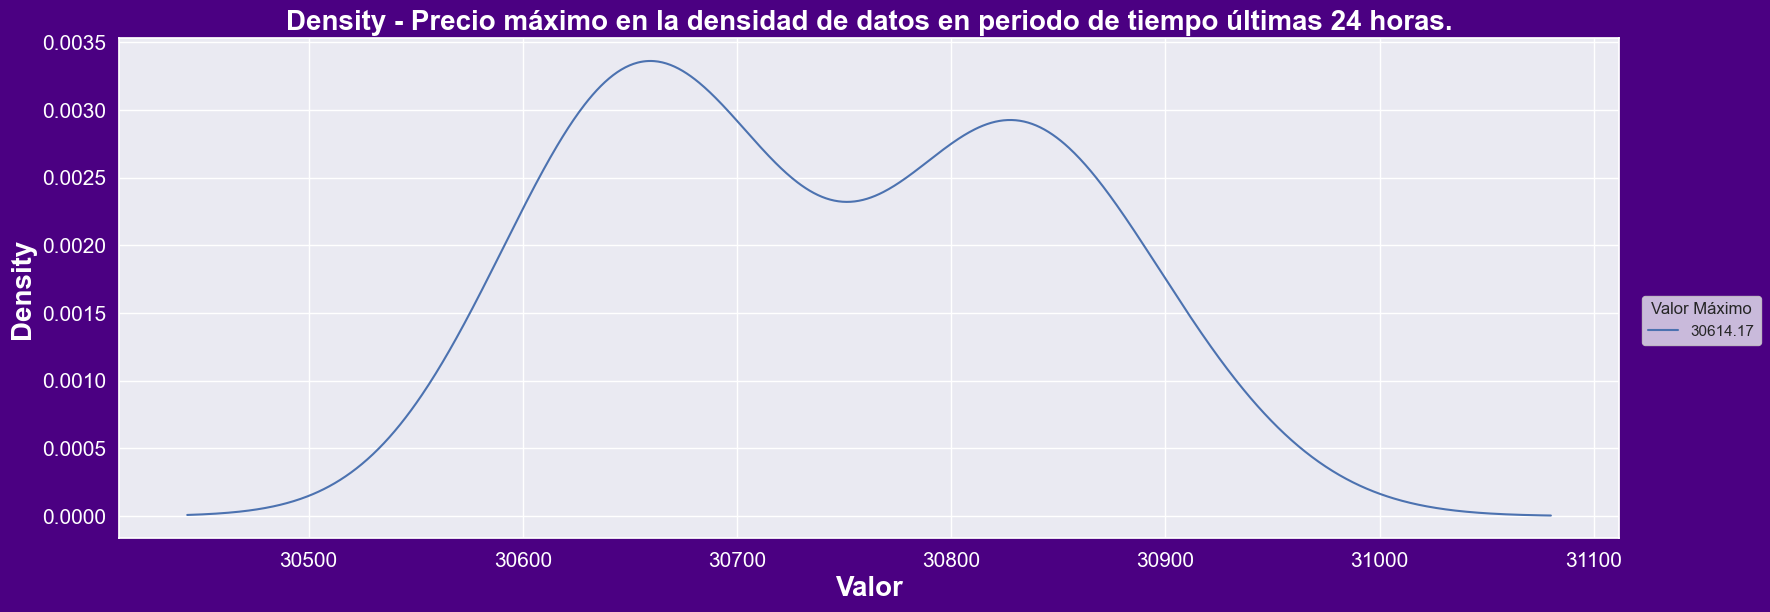

In [48]:
def density():
    fig = plt.figure(figsize=(15, 5), facecolor='indigo')
    eje = fig.add_axes([0, 0, 1, 1])
    plt.title('Density - Precio máximo en la densidad de datos en periodo de tiempo últimas 24 horas.', color='w', size=20, fontweight='bold')
    plt.ylabel( 'Datetime',fontsize=20, fontweight='bold', color='w')
    plt.xlabel( 'Valor',fontsize=20, fontweight='bold', color='w')
    eje.tick_params(axis='x', colors='w', labelsize=15)
    eje.tick_params(axis='y', colors='w', labelsize=15)
    datos_limpios['Close'].head(24).plot.density();
    close = datos_limpios['Close'].head(24)
    plt.legend(round(close.head(24), 2),bbox_to_anchor=(1.01, 0.5), loc='upper left', title='Valor Máximo');
    
density()

In [49]:
datos_limpios.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-23 03:50:00+00:00,30650.539062,30683.857422,30602.603516,30614.169922,348778496,0.0,0.0
2023-10-23 03:55:00+00:00,30665.847656,30747.738281,30665.847656,30734.943359,188186624,0.0,0.0
2023-10-23 04:00:00+00:00,30728.923828,30791.951172,30714.619141,30791.951172,263048192,0.0,0.0
2023-10-23 04:05:00+00:00,30785.207031,30792.054688,30652.412109,30652.412109,82834432,0.0,0.0
2023-10-23 04:10:00+00:00,30655.880859,30661.757812,30642.345703,30642.345703,125168640,0.0,0.0


In [50]:
datos_limpios = limpieza_datos()[0]

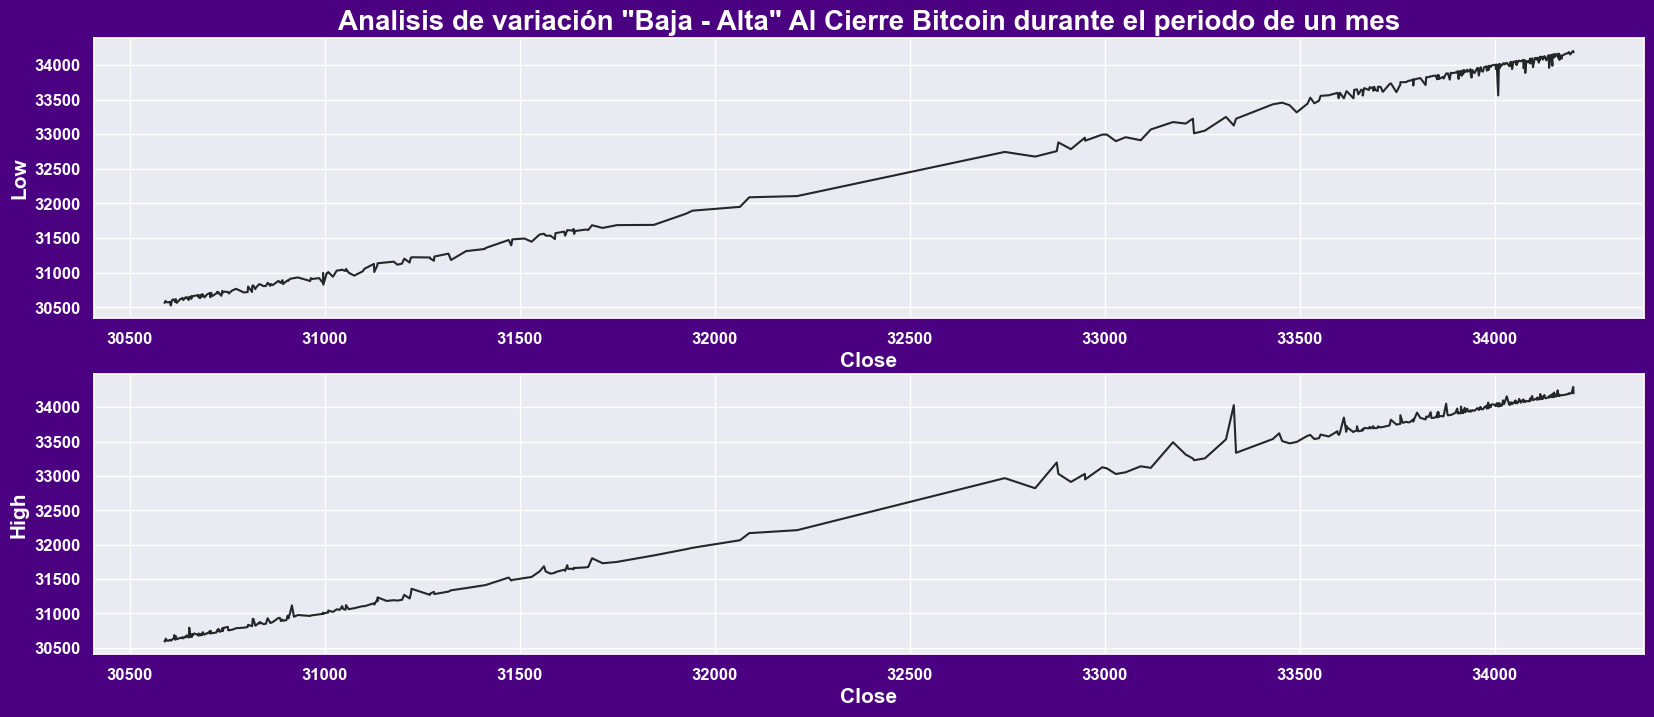

In [51]:
def comparacion_grafico(titulo, dataset, x, y1, y2):
    plt.figure(figsize=(20, 8), facecolor='indigo')
    sns.set(style="darkgrid")
    sns.set_palette('dark:skyblue')
    ax = plt.subplot(2,1,1)
    ax.set_title(titulo, color='w', size=20, fontweight='bold', loc='center')
    sns.lineplot(data=dataset, x=x, y=y1 )
    plt.ylabel(y1, color='w',fontweight='bold', size=15)
    plt.xlabel('Close', color='w',fontweight='bold', size=15)
    plt.xticks(fontweight='bold', fontsize=12, color='white')
    plt.yticks(fontweight='bold', fontsize=12, color='white')  
    plt.subplot(2,1,2)
    sns.lineplot(data=dataset, x=x, y=y2 )
    plt.ylabel(y2, color='w',fontweight='bold', size=15)
    plt.xlabel('Close', color='w',fontweight='bold', size=15)
    plt.xticks(fontweight='bold', fontsize=12, color='white')
    plt.yticks(fontweight='bold', fontsize=12, color='white')  
    plt.show()
comparacion_grafico('Analisis de variación "Baja - Alta" Al Cierre Bitcoin durante el periodo de un mes', datos_limpios.head(720), 'Close', 'Low', 'High')

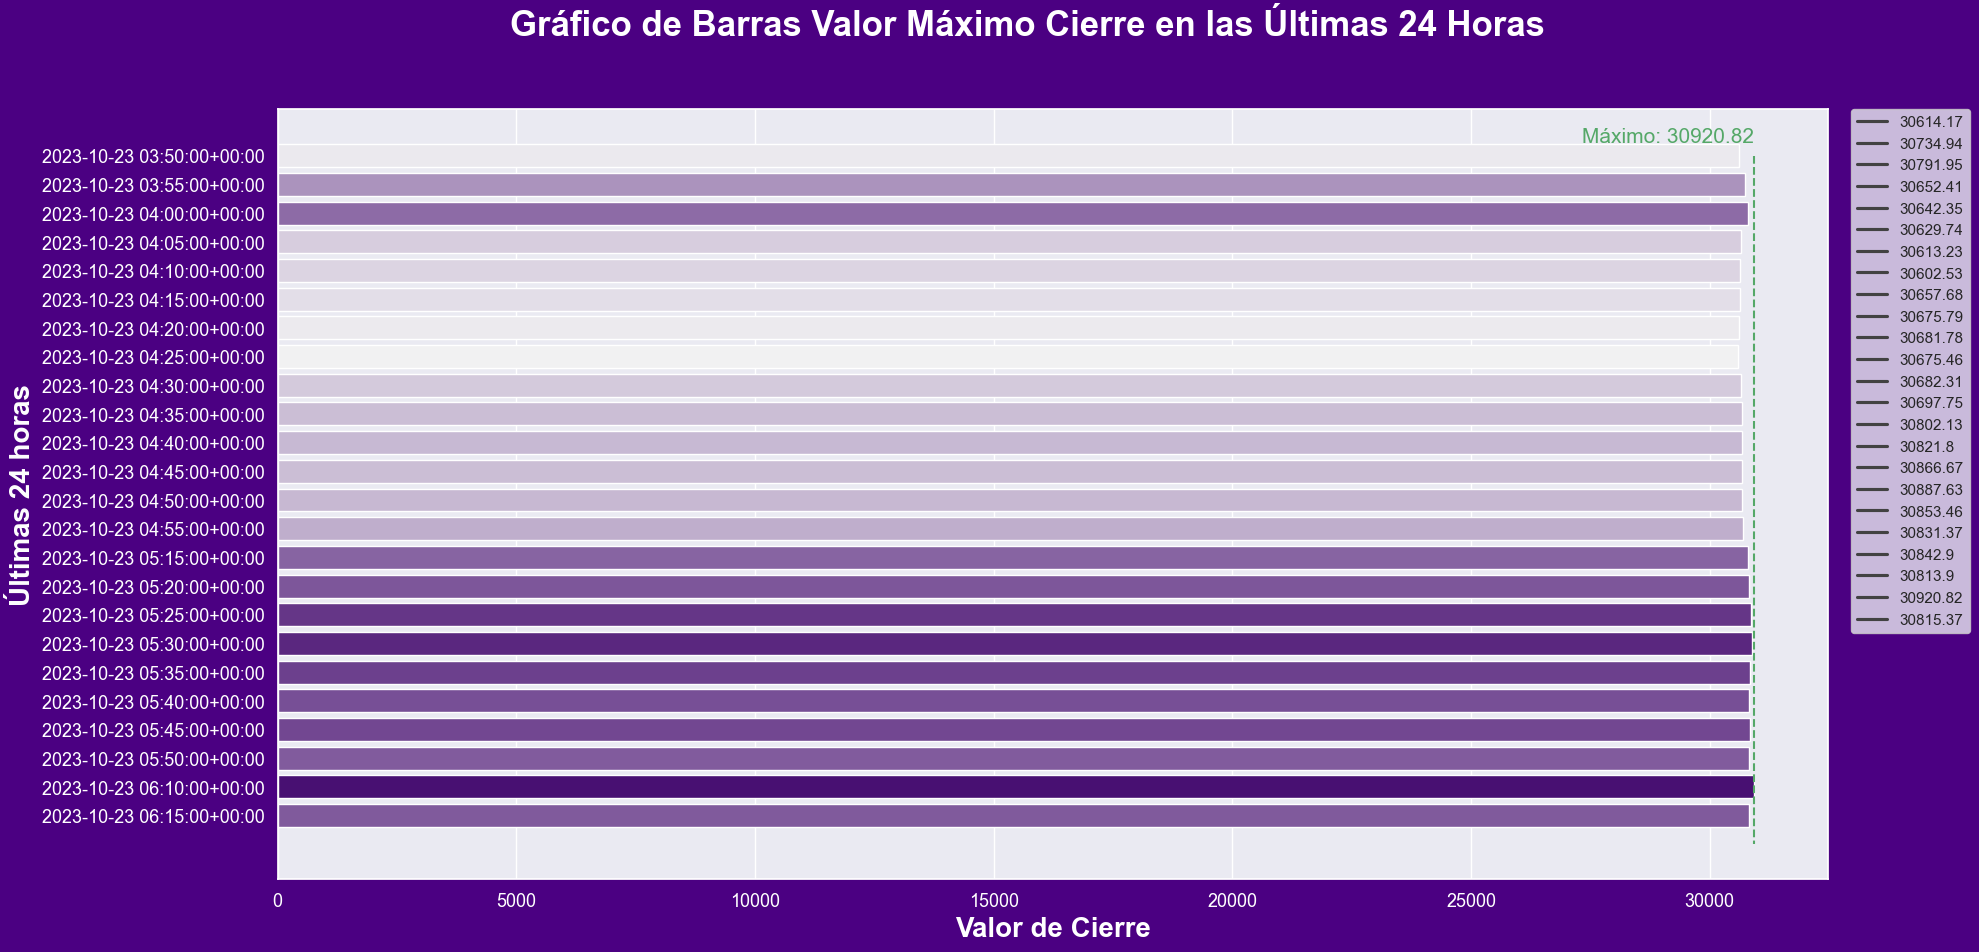

In [52]:
def maximo_ultimas_24_horas():
    plt.figure(figsize=(20, 10), facecolor='indigo')
    datos_limpios = limpieza_datos()[0]
    close = datos_limpios['Close']
    sns.barplot( data=datos_limpios.head(24), x='Close', y='Datetime', hue='Close', palette='light:indigo');
    plt.suptitle('Gráfico de Barras Valor Máximo Cierre en las Últimas 24 Horas', color='w', fontsize=25, fontweight='bold')
    plt.xlabel('Valor de Cierre',color='w', size=20, fontweight='bold')
    plt.ylabel('Últimas 24 horas', color='w', size=20, fontweight='bold')
    plt.tick_params(axis='x', colors='w', labelsize=13)
    plt.tick_params(axis='y', colors='w',labelsize=13)
    maximos = round(datos_limpios.head(24)[datos_limpios.head(24)['Close'] == datos_limpios.head(24)['Close'].max()], 2)
    plt.vlines(x=maximos['Close'], ymin=0, ymax=len(datos_limpios.head(24)), colors='g', linestyles='dashed', label='Máximo')
    for index, row in maximos.iterrows():
        plt.text(row['Close'], len(datos_limpios.head(24)) - 25, f'Máximo: {row["Close"]}', fontsize=15, ha='right', va='top', color='g')
    plt.gray()
    plt.legend(round(close.head(24), 2),bbox_to_anchor=(1.01, 1.01), loc='upper left')
    plt.show()
maximo_ultimas_24_horas()

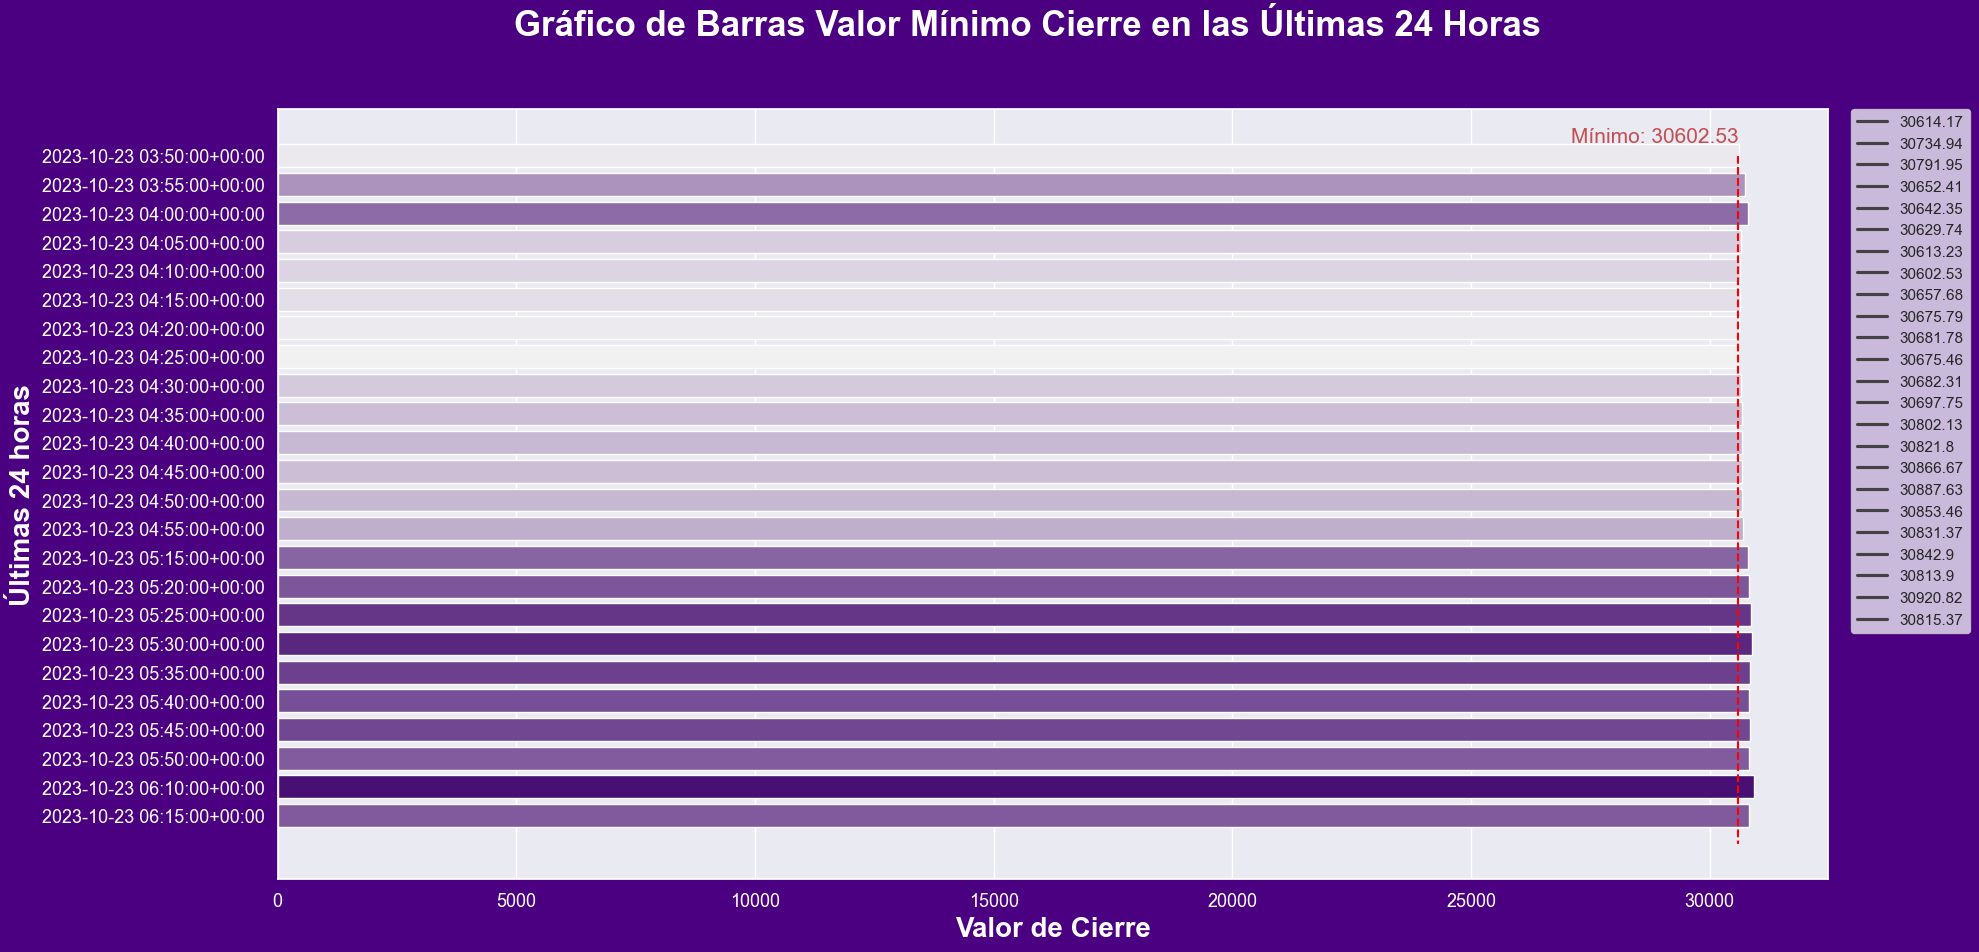

In [53]:
def minimo_ultimas_24_horas():
    plt.figure(figsize=(20, 10), facecolor='indigo')
    datos_limpios = limpieza_datos()[0]
    close = datos_limpios['Close']

    # sns.set(style="darkgrid")
    sns.barplot( data=datos_limpios.head(24), x='Close', y='Datetime', hue='Close', palette='light:indigo');
    plt.suptitle('Gráfico de Barras Valor Mínimo Cierre en las Últimas 24 Horas', color='w', fontsize=25, fontweight='bold')
    plt.xlabel('Valor de Cierre',color='w', size=20, fontweight='bold')
    plt.ylabel('Últimas 24 horas', color='w', size=20, fontweight='bold')
    plt.tick_params(axis='x', colors='w', labelsize=13)
    plt.tick_params(axis='y', colors='w',labelsize=13)
    maximos = round(datos_limpios.head(24)[datos_limpios.head(24)['Close'] == datos_limpios.head(24)['Close'].min()], 2)
    plt.vlines(x=maximos['Close'], ymin=0, ymax=len(datos_limpios.head(24)), colors='red', linestyles='dashed', label='Mínimos')
    for index, row in maximos.iterrows():
        plt.text(row['Close'], len(datos_limpios.head(24)) - 25, f'Mínimo: {row["Close"]}', fontsize=15, ha='right', va='top', color='r')
    plt.gray()
    plt.legend(round(close.head(24), 2),bbox_to_anchor=(1.01, 1.01), loc='upper left')
    plt.show()
minimo_ultimas_24_horas()

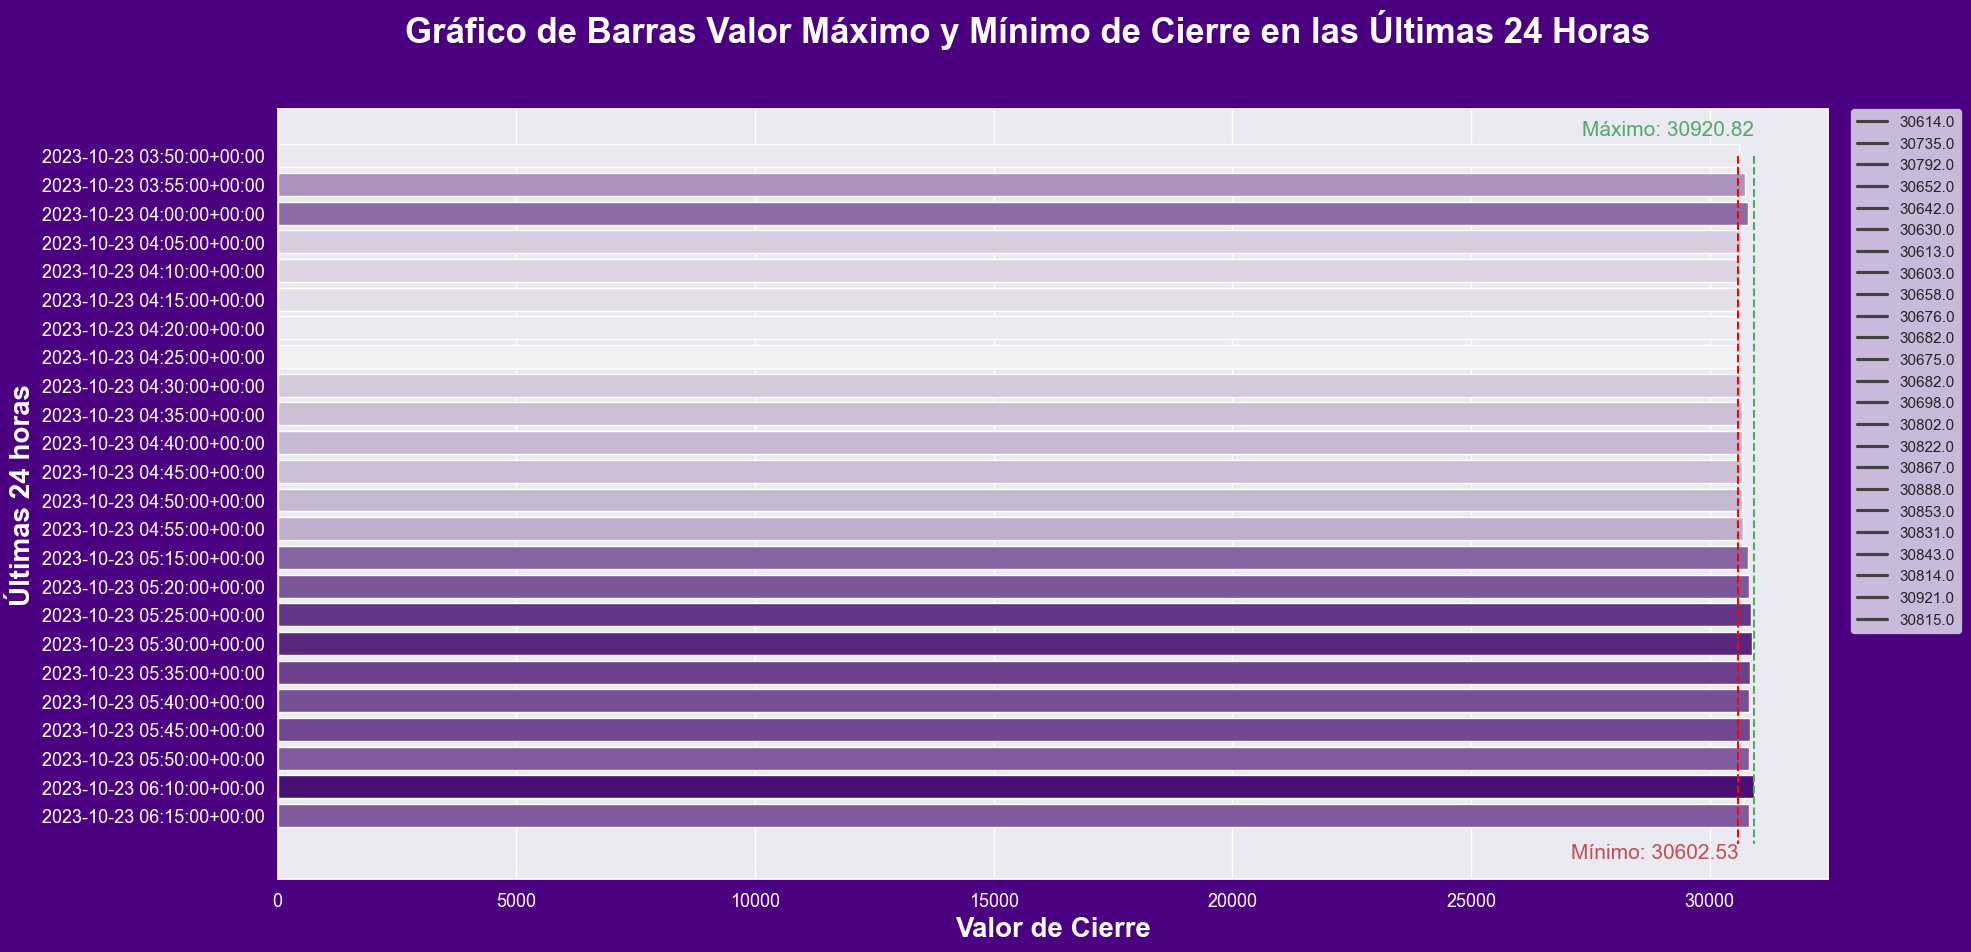

In [54]:
def maximo_minimo_ultimas_24_horas():
    plt.figure(figsize=(20, 10), facecolor='indigo')
    datos_limpios = limpieza_datos()[0]
    close = datos_limpios['Close']
    sns.barplot( data=datos_limpios.head(24), x='Close', y='Datetime', hue='Close', palette='light:indigo');
    plt.suptitle('Gráfico de Barras Valor Máximo y Mínimo de Cierre en las Últimas 24 Horas', color='w', fontsize=25, fontweight='bold')
    plt.xlabel('Valor de Cierre',color='w', size=20, fontweight='bold')
    plt.ylabel('Últimas 24 horas', color='w', size=20, fontweight='bold')
    plt.tick_params(axis='x', colors='w', labelsize=13)
    plt.tick_params(axis='y', colors='w',labelsize=13)

    maximo = round(datos_limpios.head(24)['Close'].max(), 2)
    minimo = round(datos_limpios.head(24)['Close'].min(), 2)

    plt.vlines(x=maximo, ymin=0, ymax=len(datos_limpios.head(24)), colors='g', linestyles='dashed', label='Máximos')
    plt.vlines(x=minimo, ymin=0, ymax=len(datos_limpios.head(24)), colors='red', linestyles='dashed', label='Mínimos')

    plt.text(maximo, len(datos_limpios.head(24)) - 25.25, f'Máximo: {maximo}', fontsize=15, ha='right', va='top', color='g')
    plt.text(minimo, len(datos_limpios.head(24)) - 0.05, f'Mínimo: {minimo}', fontsize=15, ha='right', va='top', color='r')

    plt.gray()
    plt.legend(round(close.head(24)),bbox_to_anchor=(1.01, 1.01), loc='upper left')
    plt.show()
maximo_minimo_ultimas_24_horas()

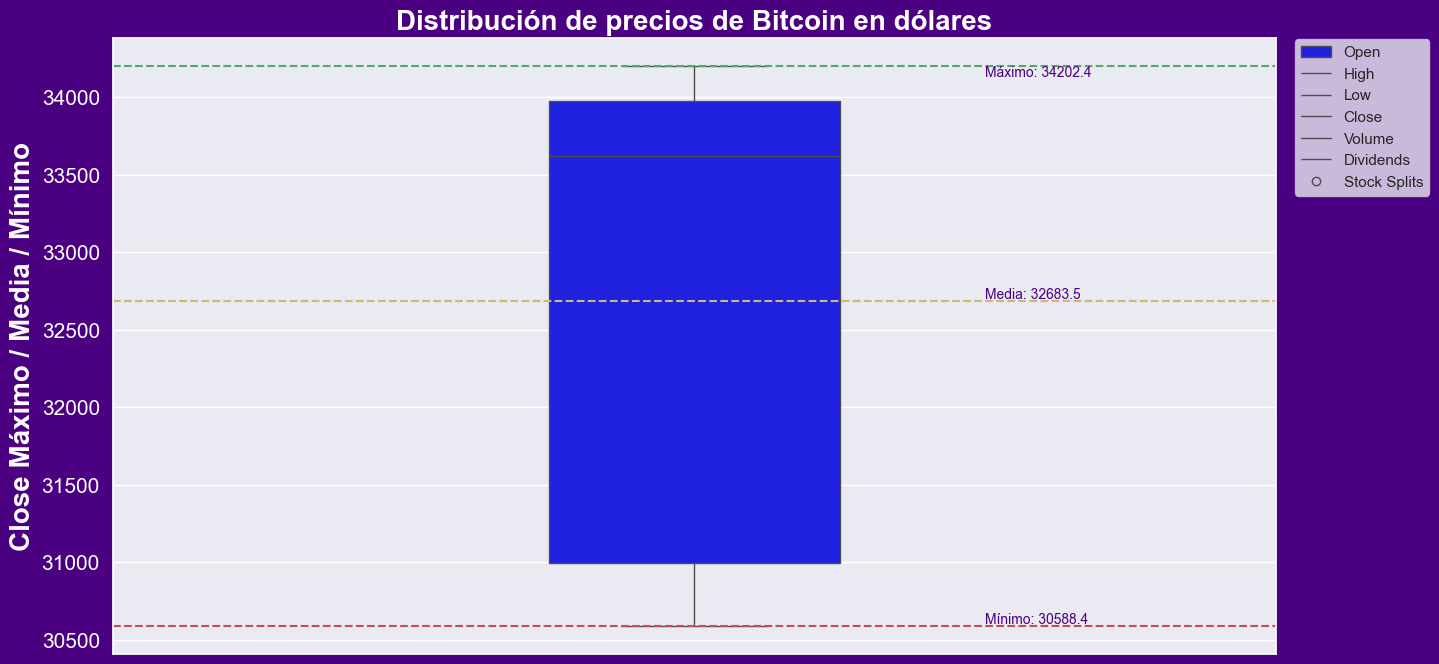

In [55]:
def boxplot1():
  # sns.set(style="darkgrid")
  plt.figure(figsize=(15, 8), facecolor='indigo')
  plt.tick_params(axis='x', colors='w', labelsize=15)
  plt.tick_params(axis='y', colors='w', labelsize=15)
 
  boxplot = sns.boxplot(y='Close', data=df_bitcoin_limpio, whis=2, width=0.25, color='blue')
  plt.title('Distribución de precios de Bitcoin en dólares', size=20, color='w',fontweight='bold')
  plt.ylabel(f'Close Máximo / Media / Mínimo', color='w',fontweight='bold', size=20)
  media = df_bitcoin_limpio['Close'].mean()
  maximo = limpieza_datos()[2]
  minimo = limpieza_datos()[1]

  boxplot.axhline(y=maximo, color='g', linestyle='--')
  boxplot.axhline(y=media, color='y', linestyle='--') 
  boxplot.axhline(y=minimo, color='r', linestyle='--') 
  
  plt.text(x=0.25, y=limpieza_datos()[2], s=f'Máximo: {limpieza_datos()[2].round(1)}', fontsize=10, va='top', color='indigo')
  plt.text(x=0.25, y=media, s=f'Media: {media.round(1)}', fontsize=10, va='bottom', color='indigo')
  plt.text(x=0.25, y=limpieza_datos()[1], s=f'Mínimo: {limpieza_datos()[1].round(1)}', fontsize=10, va='bottom', color='indigo')
  plt.gray()
  
  plt.legend(df_bitcoin_limpio,bbox_to_anchor=(1.01, 1.01), loc='upper left')
  return plt.show()

boxplot1()

4.Toma de desición Compra / Vanta / Espera

In [56]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  media_bitcoin = df_bitcoin_limpio['Close'].mean()
  if precio_actual >= media_bitcoin and tendencia == 'baja':
    algoritmo_decision = '-- Vender --'
  elif precio_actual < media_bitcoin and tendencia == 'alta':
    algoritmo_decision = '-- Comprar --'
    return algoritmo_decision
  else:
    algoritmo_decision = '-- Esperar --'
  
  return algoritmo_decision
tomar_decisiones()

'-- Esperar --'

5.Visualizando los datos / Variación de los últimos 7 días

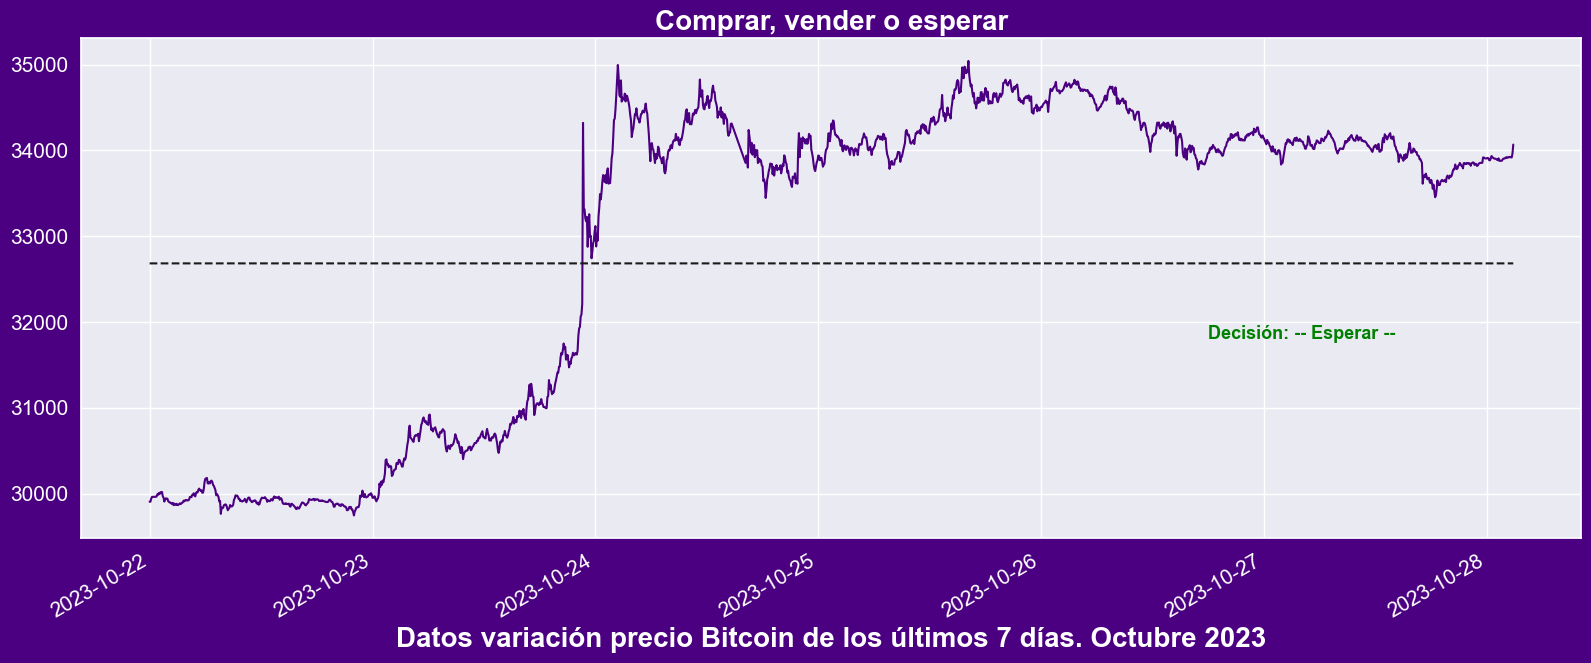

In [57]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  df_bitcoin['Promedio'] = media_bitcoin

  # sns.set(style="whitegrid")
  fig = plt.figure(figsize=(15,5), facecolor='indigo')
  eje = fig.add_axes([0,0,1,1])
  eje.tick_params(axis='x', colors='w', labelsize=15)
  eje.tick_params(axis='y', colors='w', labelsize=15)
  
  eje.set_title('Comprar, vender o esperar', fontsize=20,fontweight='bold', color='w')
  df_bitcoin['Close'].plot(legend = None, color = 'indigo')
  df_bitcoin['Promedio'].plot(legend = None, ls='--', color = 'k', fontsize=15)
  
  eje.set_xlabel('Datos variación precio Bitcoin de los últimos 7 días. Octubre 2023', fontsize=20, fontweight='bold', color='w')
  eje.annotate(f'Decisión: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-220, -140), textcoords='offset points', fontsize=13, color='green',fontweight='bold')
  plt.gray()
  plt.show()

visualizacion()

In [58]:
datos_limpios.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-23 03:50:00+00:00,30650.539062,30683.857422,30602.603516,30614.169922,348778496,0.0,0.0
2023-10-23 03:55:00+00:00,30665.847656,30747.738281,30665.847656,30734.943359,188186624,0.0,0.0
2023-10-23 04:00:00+00:00,30728.923828,30791.951172,30714.619141,30791.951172,263048192,0.0,0.0
2023-10-23 04:05:00+00:00,30785.207031,30792.054688,30652.412109,30652.412109,82834432,0.0,0.0
2023-10-23 04:10:00+00:00,30655.880859,30661.757812,30642.345703,30642.345703,125168640,0.0,0.0


In [59]:
def grafico3(titulo, x, y , xlabel, ylabel, dataset):
    plt.figure(figsize=(20, 5), facecolor='indigo')
    sns.set(style="darkgrid")
    sns.set_palette('dark:skyblue')
    datos_limpios['Close'].plot()
    plt.title(titulo, color='w', size=20, fontweight='bold', loc='center')
    plt.xlabel(xlabel, color='w', fontweight='bold', size=20)
    plt.ylabel(ylabel, color='w',fontweight='bold', size=20)
    plt.xticks(fontweight='bold', fontsize=12, color='white')  # Haz que los números del eje x sean más gruesos
    plt.yticks(fontweight='bold', fontsize=12, color='white')  # Haz que los números del eje y sean más gruesos
    plt.legend(datos_limpios['Close'], bbox_to_anchor=(1.01,0.5), loc='upper left',title='Último Precio de Cierre')
    plt.show()

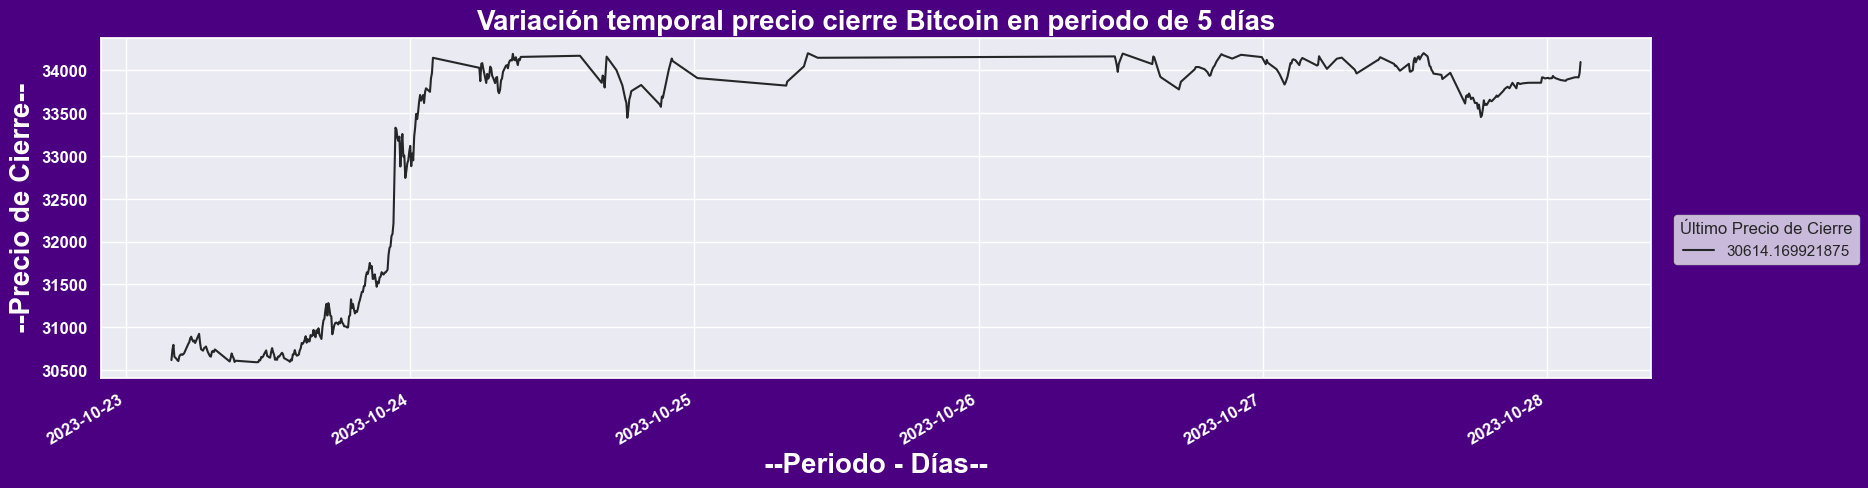

In [60]:
grafico3('Variación temporal precio cierre Bitcoin en periodo de 5 días', 'Datetime','Close', '--Periodo - Días--', '--Precio de Cierre--',datos_limpios)

6.Automatizamos el sistema 

Precio actual de Bitcoin: 34097.77
Tendencia: alta
Variación: 0.57%
Hora de verificación: 23:50:55
Ejecuciones: 1
Decisión: -- Esperar --


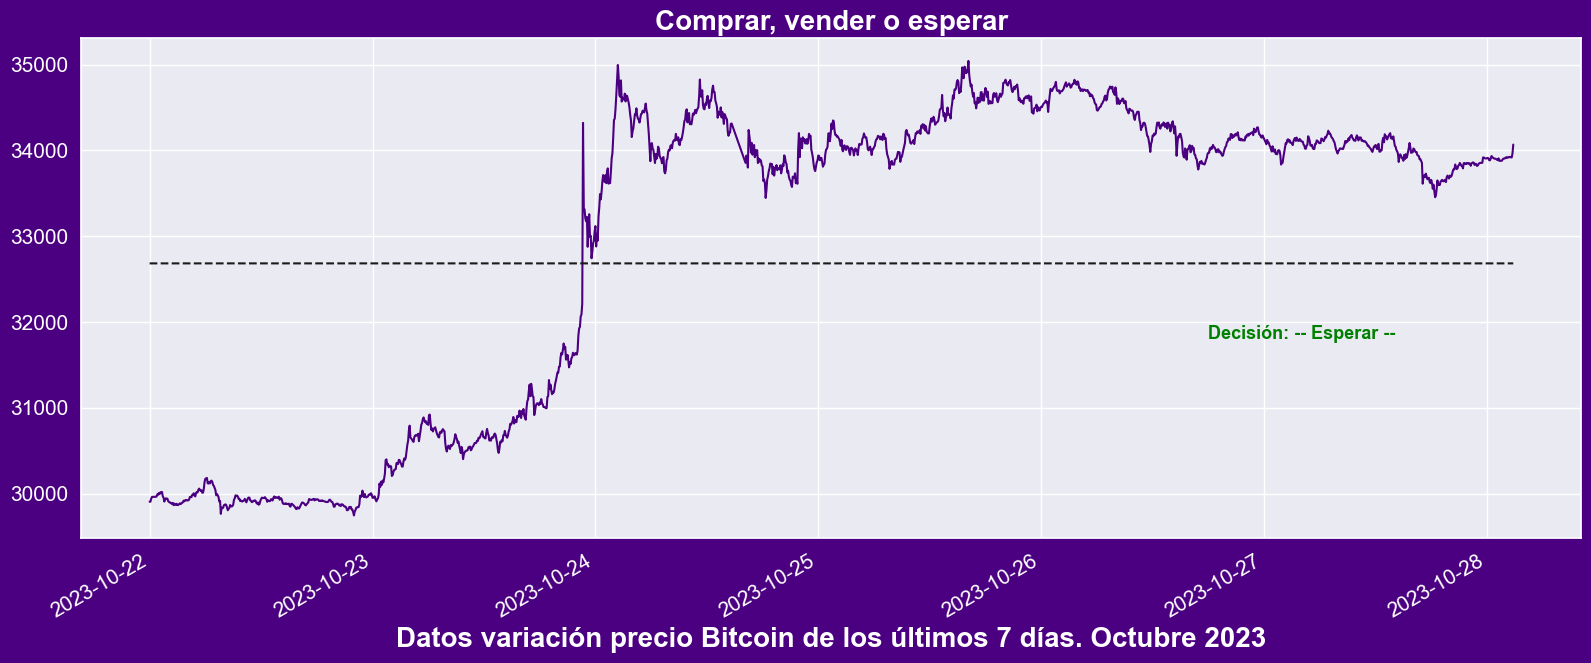

In [61]:
  
def automatizado(): 
  contador = 0 
  while True:
    contador += 1
    clear_output(wait=True)
    importar_base_bitcoin()
    extraer_tendencias()
    limpieza_datos()
    tomar_decisiones()
    tz = pytz.timezone('America/Argentina/Buenos_Aires')
    now = datetime.datetime.now(tz)
    print("Hora de verificación:", now.strftime("%H:%M:%S"))
    print(f'Ejecuciones: {contador}')
    print('Decisión:', tomar_decisiones())
    # print('Decisión:', tomar_decisiones()),print('Tendencia:',tendencia),print('Media:',int(media_bitcoin)),print('Precio:',int(precio_actual))
    visualizacion()
    time.sleep(300)
automatizado()


La toma de datos de variación de precio del bitcoin de los últimos 7 días es un proceso que consiste en recopilar información sobre el precio del bitcoin en un período de tiempo determinado. Esta información se puede utilizar para realizar análisis de tendencias y proyecciones del precio futuro de la moneda.
En nuestro caso para la toma de desiciones de Compra / Venta / Espera según situación y conveniencia.
Web scraping: Este método permite extraer datos de una página web utilizando un script o programa.
Una vez que se han recopilado los datos, se pueden almacenar en una base de datos o en un archivo CSV. Los datos se pueden analizar utilizando una variedad de herramientas y técnicas, como hojas de cálculo, software de análisis de datos y lenguajes de programación.
Una vez que se han recopilado los datos, se pueden analizar para obtener información sobre la variación de precio del bitcoin de los últimos 7 días. Por ejemplo, se puede calcular el rendimiento diario del bitcoin o el porcentaje de variación de precio del bitcoin en un período de tiempo determinado.